# Wrangle Superfund Site Data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# change default figure size
plt.rcParams['figure.figsize'] = (20, 10)

### Explore initial superfund site dataset extracted from the Superfund Enterprise Management System (SEMS)

In [103]:
# read data in
df = pd.read_csv('../data/superfund-sites.csv', encoding='utf-8')
df

,SEMS EPA ID,Facility Information,SITE NAME,ADDRESS,COUNTY,FEDERAL FACILITY,NPL STATUS,NON-NPL STATUS,LATITUDE/LONGITUDE
0,AK4170024323,View Facility Information,ADAK NAVAL AIR STATION SITE,"MAIN RDADAK, AK 99546",ALEUTIANS WEST,Y,Currently on the Final NPL,NaN,Latitude: 51.8775Longitude: -176.6525
1,AKN001002509,View Facility Information,AKUTAN NAVAL STATION,"AKUTAN HARBORAKUTAN, AK 99553",ALEUTIANS EAST,N,Not on the NPL,NFRAP-Site does not qualify for the NPL based ...,Latitude: 54.125236Longitude: -165.795091
2,AKD004904215,View Facility Information,ALASKA BATTERY ENTERPRISES CLEANUP,"157 OLD RICHARDSON HWYFAIRBANKS, AK 99701",FAIRBANKS NORTH STAR,N,Deleted from the Final NPL,NaN,Latitude: 64.8203Longitude: -147.7038
3,AK0001413772,View Facility Information,ALASKA MARITIME NWR KISKA ISLAND USFWS,"KISKA ISLANDADAK, AK 99546",ALEUTIANS WEST,Y,Not on the NPL,Other Cleanup Activity: Federal Facility-Lead ...,Latitude: 51.991096Longitude: 177.519184
4,AK0001413699,View Facility Information,ALASKA MARITIME NWR TANAGA ISLAND,"TANAGA ISLANDADAK, AK 99546",ALEUTIANS WEST,Y,Not on the NPL,Other Cleanup Activity: Federal Facility-Lead ...,Latitude: 51.671389Longitude: -178.051111
...,...,...,...,...,...,...,...,...,...
9366,PRN000206062,View Facility Information,AUTO PIEZAS JAVY,"ROAD 103, KM 7.1CABO ROJO, PR 00623",CABO ROJO,N,Not on the NPL,NFRAP-Site does not qualify for the NPL based ...,Latitude: 18.082573Longitude: -67.15072
9367,PR0000834523,View Facility Information,AVON PRODUCTS INC,"PR-1 KM 26.4CAGUAS, PR 00725",CAGUAS,N,Not on the NPL,NFRAP-Site does not qualify for the NPL based ...,Latitude: 18.301107Longitude: -66.062383
9368,PRD980509129,View Facility Information,BARCELONETA LANDFILL,"PR-666 BO FLORIDA AFUERABARCELONETA, PR 00617",BARCELONETA,N,Deleted from the Final NPL,NaN,Latitude: 18.41055Longitude: -66.547781
9369,PRN000206680,View Facility Information,BARRIO CARRERAS ABANDONED DRUM,"PR-405 KM 2.0 INTERIORA?ASCO, PR 00610",A?ASCO,N,Not on the NPL,Removal Only Site (No Site Assessment Work Nee...,NaN


The initial Superfund Site dataset only has basic location information, the EPA ID, and NPL status. The National Priority List (NPL) is used to prioritze Superfund sites. A site must have a HRS (hazard ranking system) score of at least 28.5 to be eligible for the NPL.

There are 9,371 total Superfund sites. There is a column with latitude and longitude values that will need to be wrangled into just the coordinate values before I can convert into a geodataframe.

In [104]:
# first create separate latitude and longitude columns, by splitting the joined column by 'Longitude:'
df[['LATITUDE','LONGITUDE']] = df["LATITUDE/LONGITUDE"].str.split("Longitude:", n = 1, expand = True)

# then reduce the latitude column to just the coordinate by stripping off the first 9 characters, 'Latitude:'
df['LATITUDE'] = df['LATITUDE'].str[9:]

# inspect dataframe
df.head()

,SEMS EPA ID,Facility Information,SITE NAME,ADDRESS,COUNTY,FEDERAL FACILITY,NPL STATUS,NON-NPL STATUS,LATITUDE/LONGITUDE,LATITUDE,LONGITUDE
0,AK4170024323,View Facility Information,ADAK NAVAL AIR STATION SITE,"MAIN RDADAK, AK 99546",ALEUTIANS WEST,Y,Currently on the Final NPL,NaN,Latitude: 51.8775Longitude: -176.6525,51.8775,-176.6525
1,AKN001002509,View Facility Information,AKUTAN NAVAL STATION,"AKUTAN HARBORAKUTAN, AK 99553",ALEUTIANS EAST,N,Not on the NPL,NFRAP-Site does not qualify for the NPL based ...,Latitude: 54.125236Longitude: -165.795091,54.125236,-165.795091
2,AKD004904215,View Facility Information,ALASKA BATTERY ENTERPRISES CLEANUP,"157 OLD RICHARDSON HWYFAIRBANKS, AK 99701",FAIRBANKS NORTH STAR,N,Deleted from the Final NPL,NaN,Latitude: 64.8203Longitude: -147.7038,64.8203,-147.7038
3,AK0001413772,View Facility Information,ALASKA MARITIME NWR KISKA ISLAND USFWS,"KISKA ISLANDADAK, AK 99546",ALEUTIANS WEST,Y,Not on the NPL,Other Cleanup Activity: Federal Facility-Lead ...,Latitude: 51.991096Longitude: 177.519184,51.991096,177.519184
4,AK0001413699,View Facility Information,ALASKA MARITIME NWR TANAGA ISLAND,"TANAGA ISLANDADAK, AK 99546",ALEUTIANS WEST,Y,Not on the NPL,Other Cleanup Activity: Federal Facility-Lead ...,Latitude: 51.671389Longitude: -178.051111,51.671389,-178.051111


In [105]:
# drop irrelevant columns and create new superfund dataframe
superfund = df.drop(['Facility Information', 'NON-NPL STATUS', 'ADDRESS', 'COUNTY', 'FEDERAL FACILITY', 'LATITUDE/LONGITUDE'], axis=1)

# replace spaces in column names with underscores
superfund.columns = superfund.columns.str.replace(' ', '_')
superfund

,SEMS_EPA_ID,SITE_NAME,NPL_STATUS,LATITUDE,LONGITUDE
0,AK4170024323,ADAK NAVAL AIR STATION SITE,Currently on the Final NPL,51.8775,-176.6525
1,AKN001002509,AKUTAN NAVAL STATION,Not on the NPL,54.125236,-165.795091
2,AKD004904215,ALASKA BATTERY ENTERPRISES CLEANUP,Deleted from the Final NPL,64.8203,-147.7038
3,AK0001413772,ALASKA MARITIME NWR KISKA ISLAND USFWS,Not on the NPL,51.991096,177.519184
4,AK0001413699,ALASKA MARITIME NWR TANAGA ISLAND,Not on the NPL,51.671389,-178.051111
...,...,...,...,...,...
9366,PRN000206062,AUTO PIEZAS JAVY,Not on the NPL,18.082573,-67.15072
9367,PR0000834523,AVON PRODUCTS INC,Not on the NPL,18.301107,-66.062383
9368,PRD980509129,BARCELONETA LANDFILL,Deleted from the Final NPL,18.41055,-66.547781
9369,PRN000206680,BARRIO CARRERAS ABANDONED DRUM,Not on the NPL,NaN,NaN


### Join more site details to superfund point locations

I was able to find additional data about each site through an advanced search on the EPA's website. The site allows the search results to be exported to excel.

There are over 9,000 Superfund sites total. For this project I want to focus on the NPL, or the most hazardous sites. I included all active sites currently on, proposed, or deleted from the NPL in my search. I also included Superfund Alternative Approach (SAA) sites. The Superfund Alternative (SA) approach uses the same investigation and cleanup process and standards that are used for sites listed on the NPL, but can save time and resources by not undergoing the process to actually place the site on the NPL even though the qualify for the NPL.

In [106]:
# read site details in
details = pd.read_csv('../data/superfund-site-details.csv', encoding='utf-8')
details

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 631: invalid start byte

In [107]:
# view available columns
list(details.columns)

['EPA ID',
 'Site Name',
 'City',
 'County',
 'State',
 'Street Address',
 'Zip Code',
 'Region',
 'NPL Status',
 'Partial NPL Deletion',
 'Superfund Alternative Approach',
 'Site-wide Ready for Anticipated Use',
 'Human Exposure Under Control',
 'Groundwater Migration Under Control',
 'Construction Complete',
 'Construction Completion Date',
 'Non-NPL Status Category',
 'Non-NPL Status Subcategory',
 'Non-NPL Status',
 'Site Status',
 'Site Type',
 'Site Type Subcategory',
 'Federal Agency',
 'Native American Interest',
 'Indian Entity',
 'HRS Score',
 'Federal Facility Indicator',
 'Alias/Alternative Site Name',
 'Non-NPL Status Date',
 'Superfund Site Profile Page URL']

In [108]:
# create new dataframe with only the columns I want
details_filter = details.filter(['EPA ID', # use to join to site point locations
                                        'City', # for now I will keep all location fields
                                        'County',
                                        'State',
                                        'Street Address',
                                        'Zip Code',
                                        'Region', # EPA region
                                        'NPL Status', # to determine NPL status
                                        'Superfund Alternative Approach', # to determine SAA status
                                        'Site-wide Ready for Anticipated Use',
                                        'Human Exposure Under Control', 
                                        'Groundwater Migration Under Control',
                                        'Construction Compete',
                                        'Construction Completion Date',
                                        'Site Type',
                                        'Native American Interest',
                                        'Indian Entity',
                                        'HRS Score', 
                                        'Superfund Site Profile Page URL'])
details_filter

,EPA ID,City,County,State,Street Address,Zip Code,Region,NPL Status,Superfund Alternative Approach,Site-wide Ready for Anticipated Use,Human Exposure Under Control,Groundwater Migration Under Control,Construction Completion Date,Site Type,Native American Interest,Indian Entity,HRS Score,Superfund Site Profile Page URL
0,NED981713837,COLUMBUS,PLATTE,NE,28TH AVE & 10TH ST,68601,R07,Final NPL,No,Yes,Yes,Yes,6/22/2007,Other,No,NaN,28.90,www.epa.gov/superfund/10thstreet
1,KSD007241656,WICHITA,SEDGWICK,KS,412 E 29TH N 26S 1E SW 1/4 S 33,67219,R07,Deleted NPL,No,No,No,Yes,NaN,Other,No,NaN,NaN,www.epa.gov/superfund/29thandmead
2,ALN000410750,BIRMINGHAM,JEFFERSON,AL,3500 35TH N.,35207,R04,Proposed NPL,No,No,Status Unavailable,Status Unavailable,NaN,"Manufacturing/Processing/Maintenance, Other, O...",No,NaN,50.00,www.epa.gov/superfund/35th-avenue
3,KSD981710247,WICHITA,SEDGWICK,KS,57TH & N BROADWAY STREETS,67219,R07,Final NPL,No,Yes,Yes,Yes,9/10/2002,Other,No,NaN,50.00,www.epa.gov/superfund/57thandbroadway
4,MDD980918387,ROSEDALE,BALTIMORE,MD,68TH STREET,21237,R03,Proposed NPL,Yes,No,Yes,Yes,NaN,"Waste Management, Waste Management",No,NaN,50.00,www.epa.gov/superfund/68thstreet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,NYD000511733,MOIRA,FRANKLIN,NY,N LAWRENCE RD,12957,R02,Final NPL,No,Yes,Yes,Yes,9/24/2002,Recycling,No,NaN,47.70,www.epa.gov/superfund/york-oil
1865,AZ0971590062,YUMA,YUMA,AZ,AVENUE 3E,85369,R09,Final NPL,No,Yes,Yes,Yes,9/20/2000,Manufacturing/Processing/Maintenance,No,NaN,32.24,www.epa.gov/superfund/yumausmc
1866,OHD980794598,ZANESVILLE,MUSKINGUM,OH,2200 LINDEN,43701,R05,Final NPL,No,Yes,Yes,Yes,9/3/1996,Other,No,NaN,35.59,www.epa.gov/superfund/zanesville-wellfield
1867,FLD049985302,ZELLWOOD,ORANGE,FL,803 JONES AVE,32757,R04,Final NPL,No,No,Yes,Yes,9/16/2003,Recycling,No,NaN,51.91,www.epa.gov/superfund/zellwood-groundwater-con...


In [109]:
# rename ID column to match superfund dataframe
details_filter = details_filter.rename(columns = {'EPA ID':'SEMS_EPA_ID'})

# replace spaces in column names with underscores
details_filter.columns = details_filter.columns.str.replace(' ', '_')

# replace dashes in column names with underscores
details_filter.columns = details_filter.columns.str.replace('-', '_')

#convert column names to uppercase
details_filter.columns = map(str.upper, details_filter.columns)

details_filter

,SEMS_EPA_ID,CITY,COUNTY,STATE,STREET_ADDRESS,ZIP_CODE,REGION,NPL_STATUS,SUPERFUND_ALTERNATIVE_APPROACH,SITE_WIDE_READY_FOR_ANTICIPATED_USE,HUMAN_EXPOSURE_UNDER_CONTROL,GROUNDWATER_MIGRATION_UNDER_CONTROL,CONSTRUCTION_COMPLETION_DATE,SITE_TYPE,NATIVE_AMERICAN_INTEREST,INDIAN_ENTITY,HRS_SCORE,SUPERFUND_SITE_PROFILE_PAGE_URL
0,NED981713837,COLUMBUS,PLATTE,NE,28TH AVE & 10TH ST,68601,R07,Final NPL,No,Yes,Yes,Yes,6/22/2007,Other,No,NaN,28.90,www.epa.gov/superfund/10thstreet
1,KSD007241656,WICHITA,SEDGWICK,KS,412 E 29TH N 26S 1E SW 1/4 S 33,67219,R07,Deleted NPL,No,No,No,Yes,NaN,Other,No,NaN,NaN,www.epa.gov/superfund/29thandmead
2,ALN000410750,BIRMINGHAM,JEFFERSON,AL,3500 35TH N.,35207,R04,Proposed NPL,No,No,Status Unavailable,Status Unavailable,NaN,"Manufacturing/Processing/Maintenance, Other, O...",No,NaN,50.00,www.epa.gov/superfund/35th-avenue
3,KSD981710247,WICHITA,SEDGWICK,KS,57TH & N BROADWAY STREETS,67219,R07,Final NPL,No,Yes,Yes,Yes,9/10/2002,Other,No,NaN,50.00,www.epa.gov/superfund/57thandbroadway
4,MDD980918387,ROSEDALE,BALTIMORE,MD,68TH STREET,21237,R03,Proposed NPL,Yes,No,Yes,Yes,NaN,"Waste Management, Waste Management",No,NaN,50.00,www.epa.gov/superfund/68thstreet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,NYD000511733,MOIRA,FRANKLIN,NY,N LAWRENCE RD,12957,R02,Final NPL,No,Yes,Yes,Yes,9/24/2002,Recycling,No,NaN,47.70,www.epa.gov/superfund/york-oil
1865,AZ0971590062,YUMA,YUMA,AZ,AVENUE 3E,85369,R09,Final NPL,No,Yes,Yes,Yes,9/20/2000,Manufacturing/Processing/Maintenance,No,NaN,32.24,www.epa.gov/superfund/yumausmc
1866,OHD980794598,ZANESVILLE,MUSKINGUM,OH,2200 LINDEN,43701,R05,Final NPL,No,Yes,Yes,Yes,9/3/1996,Other,No,NaN,35.59,www.epa.gov/superfund/zanesville-wellfield
1867,FLD049985302,ZELLWOOD,ORANGE,FL,803 JONES AVE,32757,R04,Final NPL,No,No,Yes,Yes,9/16/2003,Recycling,No,NaN,51.91,www.epa.gov/superfund/zellwood-groundwater-con...


In [132]:
# join details to superfund site points
# using right join to keep only the sites currently on, proposed, or deleted from NPL, or SAA sites
joined = pd.merge(superfund, details_filter, on='SEMS_EPA_ID', how='right')
joined

,SEMS_EPA_ID,SITE_NAME,NPL_STATUS_x,LATITUDE,LONGITUDE,CITY,COUNTY,STATE,STREET_ADDRESS,ZIP_CODE,...,SUPERFUND_ALTERNATIVE_APPROACH,SITE_WIDE_READY_FOR_ANTICIPATED_USE,HUMAN_EXPOSURE_UNDER_CONTROL,GROUNDWATER_MIGRATION_UNDER_CONTROL,CONSTRUCTION_COMPLETION_DATE,SITE_TYPE,NATIVE_AMERICAN_INTEREST,INDIAN_ENTITY,HRS_SCORE,SUPERFUND_SITE_PROFILE_PAGE_URL
0,AK4170024323,ADAK NAVAL AIR STATION SITE,Currently on the Final NPL,51.8775,-176.6525,ADAK,[Blank County],AK,ADAK IS,99546,...,No,No,Yes,Yes,NaN,Other,No,NaN,51.37,www.epa.gov/superfund/adak-nas
1,AKD004904215,ALASKA BATTERY ENTERPRISES CLEANUP,Deleted from the Final NPL,64.8203,-147.7038,FAIRBANKS,FAIRBANKS NORTH STAR,AK,157 OLD RICHARDSON HIGHWAY,99701,...,No,No,Yes,Yes,3/2/1993,Recycling,No,NaN,NaN,www.epa.gov/superfund/alaska-battery
2,AKD980983241,ALASKA RAILROAD CORP,Not on the NPL,61.22236,-149.88825,ANCHORAGE,ANCHORAGE,AK,1ST AVENUE,99501,...,Yes,No,Yes,Insufficient Data,NaN,Other,No,NaN,NaN,www.epa.gov/superfund/alaska-railroad-anchorag...
3,AKD980988158,ARCTIC SURPLUS,Deleted from the Final NPL,64.8122,-147.5643,FAIRBANKS,[Blank County],AK,BADGER RD AND OLD RICHARDSON WAY MI. 6,99701,...,No,Yes,Yes,Yes,4/18/2005,Waste Management,No,NaN,NaN,www.epa.gov/superfund/arctic-surplus
4,AK1570028646,EIELSON AIR FORCE BASE,Currently on the Final NPL,64.67145,-147.0492,FAIRBANKS,FAIRBANKS NORTH STAR,AK,HIGHWAY 2 - 16 MI SE OF FAIRBANKS,99702,...,No,No,Yes,Insufficient Data,9/30/1998,Waste Management,No,NaN,48.14,www.epa.gov/superfund/eielson-afb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,WIN000509953,NaN,NaN,NaN,NaN,TWO RIVERS,MANITOWOC,WI,2000 21ST STREET,54241,...,Yes,No,Insufficient Data,Insufficient Data,NaN,Manufacturing/Processing/Maintenance,No,NaN,NaN,www.epa.gov/superfund/wpsc-two-rivers
1865,TND980844781,NaN,NaN,NaN,NaN,WRIGLEY,HICKMAN,TN,OLD CHARCOAL RD 1 MI S OF LYLE,37098,...,No,No,Yes,Insufficient Data,NaN,"Manufacturing/Processing/Maintenance, Manufact...",No,NaN,36.14,www.epa.gov/superfund/wrigley-charcoal-plant
1866,WAD009248295,NaN,NaN,NaN,NaN,BAINBRIDGE ISLAND,KITSAP,WA,5350 CREOSOTE PL NE,98110,...,No,No,No,No,NaN,Manufacturing/Processing/Maintenance,Yes,Suquamish Indian Tribe of the Port Madison Res...,32.55,www.epa.gov/superfund/wyckoff-eagle-harbor
1867,WAD040187890,NaN,NaN,NaN,NaN,YAKIMA,YAKIMA,WA,1804 S 3RD AV,98902,...,No,Yes,Yes,Not a Groundwater Site,9/30/1992,Manufacturing/Processing/Maintenance,Yes,Confederated Tribes and Bands of the Yakama Na...,NaN,www.epa.gov/superfund/yakima-plating


In [111]:
# check for null coordinate values
print(joined['LATITUDE'].isnull().sum())
print(joined['LONGITUDE'].isnull().sum())

399
399


I have 399 records from the advanced search that did not match up to point locations extracted from SEMS. I have two options, (1) drop the records that do not have lat/long values or (2) geocode the addresses with missing lat/long values. 

In [112]:
# view records with missing coordinates
missing = joined[joined['LATITUDE'].isnull()]
missing

,SEMS_EPA_ID,SITE_NAME,NPL_STATUS_x,LATITUDE,LONGITUDE,CITY,COUNTY,STATE,STREET_ADDRESS,ZIP_CODE,...,SUPERFUND_ALTERNATIVE_APPROACH,SITE_WIDE_READY_FOR_ANTICIPATED_USE,HUMAN_EXPOSURE_UNDER_CONTROL,GROUNDWATER_MIGRATION_UNDER_CONTROL,CONSTRUCTION_COMPLETION_DATE,SITE_TYPE,NATIVE_AMERICAN_INTEREST,INDIAN_ENTITY,HRS_SCORE,SUPERFUND_SITE_PROFILE_PAGE_URL
1470,ALN000410750,NaN,NaN,NaN,NaN,BIRMINGHAM,JEFFERSON,AL,3500 35TH N.,35207,...,No,No,Status Unavailable,Status Unavailable,NaN,"Manufacturing/Processing/Maintenance, Other, O...",No,NaN,50.00,www.epa.gov/superfund/35th-avenue
1471,UTD981548985,NaN,NaN,NaN,NaN,SALT LAKE CITY,SALT LAKE,UT,INTERSECTION OF 700 SOUTH & 1600 EAST,84102,...,No,No,Insufficient Data,Insufficient Data,NaN,Other,No,NaN,50.00,www.epa.gov/superfund/700-south
1472,VAD980551683,NaN,NaN,NaN,NaN,PORTSMOUTH,PORTSMOUTH CITY,VA,RANDOLPH + GREEN ST,23704,...,No,No,Yes,Yes,NaN,Manufacturing/Processing/Maintenance,No,NaN,36.53,www.epa.gov/superfund/abex
1473,SCD047563614,NaN,NaN,NaN,NaN,WILLISTON,BARNWELL,SC,3330 CRANE WAY,29853,...,Yes,No,Yes,Yes,NaN,Other,No,NaN,NaN,www.epa.gov/superfund/admiral-home-appliances
1474,TX7572024605,NaN,NaN,NaN,NaN,FORT WORTH,TARRANT,TX,GRANTS LANE,76108,...,No,Yes,Yes,Yes,9/15/2006,Manufacturing/Processing/Maintenance,No,NaN,39.92,www.epa.gov/superfund/air-force-plan-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,WIN000509953,NaN,NaN,NaN,NaN,TWO RIVERS,MANITOWOC,WI,2000 21ST STREET,54241,...,Yes,No,Insufficient Data,Insufficient Data,NaN,Manufacturing/Processing/Maintenance,No,NaN,NaN,www.epa.gov/superfund/wpsc-two-rivers
1865,TND980844781,NaN,NaN,NaN,NaN,WRIGLEY,HICKMAN,TN,OLD CHARCOAL RD 1 MI S OF LYLE,37098,...,No,No,Yes,Insufficient Data,NaN,"Manufacturing/Processing/Maintenance, Manufact...",No,NaN,36.14,www.epa.gov/superfund/wrigley-charcoal-plant
1866,WAD009248295,NaN,NaN,NaN,NaN,BAINBRIDGE ISLAND,KITSAP,WA,5350 CREOSOTE PL NE,98110,...,No,No,No,No,NaN,Manufacturing/Processing/Maintenance,Yes,Suquamish Indian Tribe of the Port Madison Res...,32.55,www.epa.gov/superfund/wyckoff-eagle-harbor
1867,WAD040187890,NaN,NaN,NaN,NaN,YAKIMA,YAKIMA,WA,1804 S 3RD AV,98902,...,No,Yes,Yes,Not a Groundwater Site,9/30/1992,Manufacturing/Processing/Maintenance,Yes,Confederated Tribes and Bands of the Yakama Na...,NaN,www.epa.gov/superfund/yakima-plating


In [113]:
# out of the records with missing coordinates,
# view records that do not begin with a street number
missing[missing['STREET_ADDRESS'].str.match(r'([^\d]+)')]

,SEMS_EPA_ID,SITE_NAME,NPL_STATUS_x,LATITUDE,LONGITUDE,CITY,COUNTY,STATE,STREET_ADDRESS,ZIP_CODE,...,SUPERFUND_ALTERNATIVE_APPROACH,SITE_WIDE_READY_FOR_ANTICIPATED_USE,HUMAN_EXPOSURE_UNDER_CONTROL,GROUNDWATER_MIGRATION_UNDER_CONTROL,CONSTRUCTION_COMPLETION_DATE,SITE_TYPE,NATIVE_AMERICAN_INTEREST,INDIAN_ENTITY,HRS_SCORE,SUPERFUND_SITE_PROFILE_PAGE_URL
1471,UTD981548985,NaN,NaN,NaN,NaN,SALT LAKE CITY,SALT LAKE,UT,INTERSECTION OF 700 SOUTH & 1600 EAST,84102,...,No,No,Insufficient Data,Insufficient Data,NaN,Other,No,NaN,50.00,www.epa.gov/superfund/700-south
1472,VAD980551683,NaN,NaN,NaN,NaN,PORTSMOUTH,PORTSMOUTH CITY,VA,RANDOLPH + GREEN ST,23704,...,No,No,Yes,Yes,NaN,Manufacturing/Processing/Maintenance,No,NaN,36.53,www.epa.gov/superfund/abex
1474,TX7572024605,NaN,NaN,NaN,NaN,FORT WORTH,TARRANT,TX,GRANTS LANE,76108,...,No,Yes,Yes,Yes,9/15/2006,Manufacturing/Processing/Maintenance,No,NaN,39.92,www.epa.gov/superfund/air-force-plan-4
1476,TNN000410203,NaN,NaN,NaN,NaN,ALAMO,CROCKETT,TN,SOUTH BELLS STREET,38001,...,No,No,Yes,Insufficient Data,NaN,Other,No,NaN,50.00,www.epa.gov/superfund/alamo-contaminated-groun...
1477,TXD008123168,NaN,NaN,NaN,NaN,POINT COMFORT,CALHOUN,TX,Postal Address is unavailable for the Site,77979,...,No,Yes,Yes,Yes,7/23/2007,Manufacturing/Processing/Maintenance,No,NaN,50.00,www.epa.gov/superfund/alcoa-lavaca-bay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,RID009764929,NaN,NaN,NaN,NaN,BURRILLVILLE,PROVIDENCE,RI,DOUGLAS PIKE,02895,...,No,Yes,Yes,Yes,12/22/1992,Waste Management,No,NaN,51.35,www.epa.gov/superfund/wsg
1855,WID980610620,NaN,NaN,NaN,NaN,LA PRAIRIE TOWNSHIP,ROCK,WI,CO TRK O & CO TRK J,53545,...,No,Yes,Yes,Yes,12/29/1992,Waste Management,No,NaN,NaN,www.epa.gov/superfund/wheeler-pit
1863,WIN000509983,NaN,NaN,NaN,NaN,STEVENS POINT,PORTAGE,WI,CROSBY AVENUE JUST NORTH OF HWY 10,54492,...,Yes,Yes,Yes,Insufficient Data,NaN,Manufacturing/Processing/Maintenance,No,NaN,NaN,www.epa.gov/superfund/wpsc-stevenspoint
1865,TND980844781,NaN,NaN,NaN,NaN,WRIGLEY,HICKMAN,TN,OLD CHARCOAL RD 1 MI S OF LYLE,37098,...,No,No,Yes,Insufficient Data,NaN,"Manufacturing/Processing/Maintenance, Manufact...",No,NaN,36.14,www.epa.gov/superfund/wrigley-charcoal-plant


Over half of the sites with missing coordinates are missing a street number. For now I am going to drop the records without coordinate values.

In [135]:
# drop records that have null values in the lat/long columns
superfund_sites = joined.dropna(subset=['LATITUDE', 'LONGITUDE'])
superfund_sites

,SEMS_EPA_ID,SITE_NAME,NPL_STATUS_x,LATITUDE,LONGITUDE,CITY,COUNTY,STATE,STREET_ADDRESS,ZIP_CODE,...,SUPERFUND_ALTERNATIVE_APPROACH,SITE_WIDE_READY_FOR_ANTICIPATED_USE,HUMAN_EXPOSURE_UNDER_CONTROL,GROUNDWATER_MIGRATION_UNDER_CONTROL,CONSTRUCTION_COMPLETION_DATE,SITE_TYPE,NATIVE_AMERICAN_INTEREST,INDIAN_ENTITY,HRS_SCORE,SUPERFUND_SITE_PROFILE_PAGE_URL
0,AK4170024323,ADAK NAVAL AIR STATION SITE,Currently on the Final NPL,51.8775,-176.6525,ADAK,[Blank County],AK,ADAK IS,99546,...,No,No,Yes,Yes,NaN,Other,No,NaN,51.37,www.epa.gov/superfund/adak-nas
1,AKD004904215,ALASKA BATTERY ENTERPRISES CLEANUP,Deleted from the Final NPL,64.8203,-147.7038,FAIRBANKS,FAIRBANKS NORTH STAR,AK,157 OLD RICHARDSON HIGHWAY,99701,...,No,No,Yes,Yes,3/2/1993,Recycling,No,NaN,NaN,www.epa.gov/superfund/alaska-battery
2,AKD980983241,ALASKA RAILROAD CORP,Not on the NPL,61.22236,-149.88825,ANCHORAGE,ANCHORAGE,AK,1ST AVENUE,99501,...,Yes,No,Yes,Insufficient Data,NaN,Other,No,NaN,NaN,www.epa.gov/superfund/alaska-railroad-anchorag...
3,AKD980988158,ARCTIC SURPLUS,Deleted from the Final NPL,64.8122,-147.5643,FAIRBANKS,[Blank County],AK,BADGER RD AND OLD RICHARDSON WAY MI. 6,99701,...,No,Yes,Yes,Yes,4/18/2005,Waste Management,No,NaN,NaN,www.epa.gov/superfund/arctic-surplus
4,AK1570028646,EIELSON AIR FORCE BASE,Currently on the Final NPL,64.67145,-147.0492,FAIRBANKS,FAIRBANKS NORTH STAR,AK,HIGHWAY 2 - 16 MI SE OF FAIRBANKS,99702,...,No,No,Yes,Insufficient Data,9/30/1998,Waste Management,No,NaN,48.14,www.epa.gov/superfund/eielson-afb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,PAD980537773,WILLIAM DICK LAGOONS,Currently on the Final NPL,40.041939,-75.898061,WEST CALN TOWNSHIP,CHESTER,PA,TELEGRAPH ROAD,19376,...,No,No,Yes,No,NaN,Waste Management,No,NaN,36.64,www.epa.gov/superfund/williamdicklagoons
1466,PAD980830715,YORK COUNTY SOLID WASTE AND REFUSE AUTHORITY L...,Deleted from the Final NPL,39.782361,-76.607219,HOPEWELL TOWNSHIP,YORK,PA,ROAD #3 - BOX 426,17363,...,No,Yes,Yes,Yes,9/29/1995,Waste Management,No,NaN,NaN,www.epa.gov/superfund/yorkcountysolidwasteandr...
1467,PAD002395887,ZINC CORPORATION OF AMERICA,Currently on the Final NPL,40.808331,-75.583339,PALMERTON,CARBON,PA,211 FRANKLIN ST,18071,...,No,No,Yes,No,NaN,Waste Management,No,NaN,42.93,www.epa.gov/superfund/palmerton
1468,PRN000204694,ATLANTIC FLEET WEAPONS TRAINING AREA,Currently on the Final NPL,18.13058,-65.3106,VIEQUES,VIEQUES,PR,Postal Address is unavailable for the Site,00765,...,No,No,No,Insufficient Data,NaN,Other,No,NaN,NaN,www.epa.gov/superfund/vieques


### Create Superfund site geodataframe and export to geojson

In [136]:
# cast lat/long columns to float
superfund_sites['LATITUDE'] = superfund_sites['LATITUDE'].astype(float)
superfund_sites['LONGITUDE'] = superfund_sites['LONGITUDE'].astype(float)

# create geodataframe using Latitude and Longitude columns
gdf = gpd.GeoDataFrame(superfund_sites, geometry=gpd.points_from_xy(superfund_sites.LONGITUDE, superfund_sites.LATITUDE))

# define crs for geodataframe
gdf.crs = {'init' :'epsg:4326'}

gdf.head()

,SEMS_EPA_ID,SITE_NAME,NPL_STATUS_x,LATITUDE,LONGITUDE,CITY,COUNTY,STATE,STREET_ADDRESS,ZIP_CODE,...,SITE_WIDE_READY_FOR_ANTICIPATED_USE,HUMAN_EXPOSURE_UNDER_CONTROL,GROUNDWATER_MIGRATION_UNDER_CONTROL,CONSTRUCTION_COMPLETION_DATE,SITE_TYPE,NATIVE_AMERICAN_INTEREST,INDIAN_ENTITY,HRS_SCORE,SUPERFUND_SITE_PROFILE_PAGE_URL,geometry
0,AK4170024323,ADAK NAVAL AIR STATION SITE,Currently on the Final NPL,51.87750,-176.65250,ADAK,[Blank County],AK,ADAK IS,99546,...,No,Yes,Yes,NaN,Other,No,NaN,51.37,www.epa.gov/superfund/adak-nas,POINT (-176.65250 51.87750)
1,AKD004904215,ALASKA BATTERY ENTERPRISES CLEANUP,Deleted from the Final NPL,64.82030,-147.70380,FAIRBANKS,FAIRBANKS NORTH STAR,AK,157 OLD RICHARDSON HIGHWAY,99701,...,No,Yes,Yes,3/2/1993,Recycling,No,NaN,NaN,www.epa.gov/superfund/alaska-battery,POINT (-147.70380 64.82030)
2,AKD980983241,ALASKA RAILROAD CORP,Not on the NPL,61.22236,-149.88825,ANCHORAGE,ANCHORAGE,AK,1ST AVENUE,99501,...,No,Yes,Insufficient Data,NaN,Other,No,NaN,NaN,www.epa.gov/superfund/alaska-railroad-anchorag...,POINT (-149.88825 61.22236)
3,AKD980988158,ARCTIC SURPLUS,Deleted from the Final NPL,64.81220,-147.56430,FAIRBANKS,[Blank County],AK,BADGER RD AND OLD RICHARDSON WAY MI. 6,99701,...,Yes,Yes,Yes,4/18/2005,Waste Management,No,NaN,NaN,www.epa.gov/superfund/arctic-surplus,POINT (-147.56430 64.81220)
4,AK1570028646,EIELSON AIR FORCE BASE,Currently on the Final NPL,64.67145,-147.04920,FAIRBANKS,FAIRBANKS NORTH STAR,AK,HIGHWAY 2 - 16 MI SE OF FAIRBANKS,99702,...,No,Yes,Insufficient Data,9/30/1998,Waste Management,No,NaN,48.14,www.epa.gov/superfund/eielson-afb,POINT (-147.04920 64.67145)


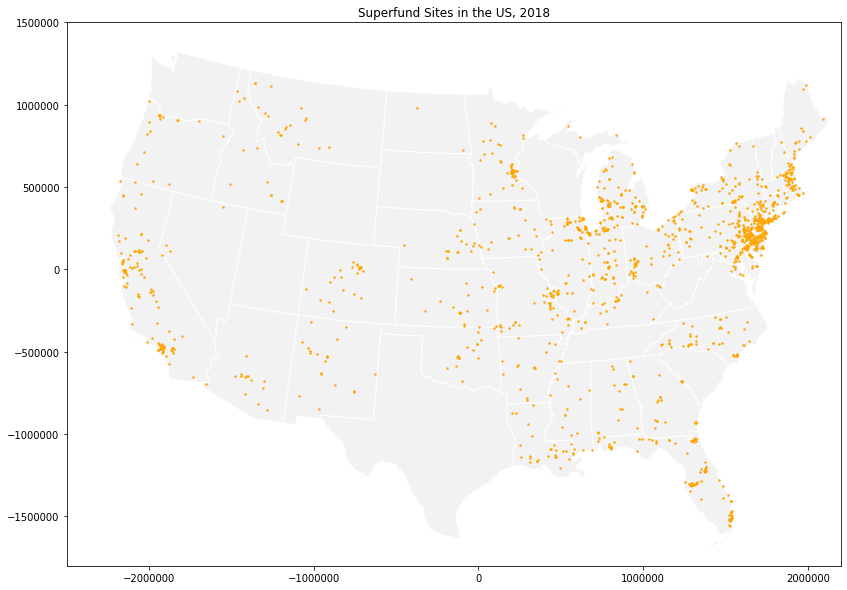

In [137]:
#plot superfund sites over state basemap to visualize distribution
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

#project each layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
gdf_equal = gdf.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

states_equal.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
gdf_equal.plot(ax=ax, color='orange', zorder=1, markersize=2);


ax.set(xlim=(-2500000,2200000), ylim=(-1800000,1500000), title='Superfund Sites in the US, 2018');

print;

In [138]:
# export geodataframe to geojson for further exploration
gdf.to_file("../data/superfund-sites-new.geojson", driver='GeoJSON', encoding='utf-8')